# Import Libraries

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load and Preprocess Dataset

In [2]:
np.random.seed(1337)
(x_train, _), (x_test, _) = mnist.load_data()
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

11493376/11490434 [==============================] - 0s 0us/step


# Generate Corrupted MNIST Images

In [6]:
noise = np.random.normal(loc=0.1, scale=0.5, size=x_train.shape)
x_train_noisy = x_train + noise
noise = np.random.normal(loc=0.1, scale=0.5, size=x_test.shape)
x_test_noisy = x_test + noise
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Model

In [7]:

input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 16
layer_filters = [32, 64]

inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for filters in layer_filters:
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=2, activation='relu', padding='same')(x)
shape = K.int_shape(x)
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=2, activation='relu', padding='same')(x)
outputs = Conv2DTranspose(filters=1, kernel_size=kernel_size, padding='same', activation='sigmoid', name='decoder_output')(x)
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

autoencoder.compile(loss='mse', optimizer='adam')

autoencoder.fit(x_train_noisy, x_train, validation_data=(x_test_noisy, x_test), epochs=10, batch_size=batch_size)

x_decoded = autoencoder.predict(x_test_noisy)

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Sh

# Display image plot

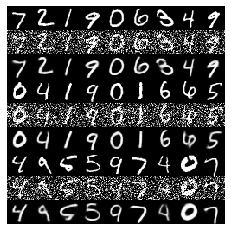

In [10]:
rows, cols = 3, 9
num = rows * cols
imgs = np.concatenate([x_test[:num], x_test_noisy[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)
plt.figure()
plt.axis('off')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.show()